## PCA Toy Example on sklearn Diabetes Dataset

### Purpose
I was learning about PCA (Principal Component Analysis) wanted to apply it to a toy example.
The intention is to practice using PCA (particularly from the sklearn library) and visualisation techniques.

I learn a little about sklearn dataset types along the way

### Notes to self
```bash
conda activate ml
jupyter notebook
```

#### Import necessary tools

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import math

#### Import toy dataset from sklearn as dataframe

In [26]:
sk_ds = datasets.load_diabetes(as_frame=True)
feat_df = sk_ds.data
feat_df.head()
label_df = sk_ds.target

#### Do some preliminary analysis & visualisation on data

In [27]:
# make them into a combined dataframe for ease of handling
combined = feat_df.copy()
combined['target'] = label_df
correlated_feats = combined.corr()['target'].sort_values(ascending=False) # see pearson correlation 
correlated_feats

target    1.000000
bmi       0.586450
s5        0.565883
bp        0.441482
s4        0.430453
s6        0.382483
s1        0.212022
age       0.187889
s2        0.174054
sex       0.043062
s3       -0.394789
Name: target, dtype: float64

In [28]:
correlated_feats = correlated_feats[1:][correlated_feats**2 > 0.01]
# correlated_values, remove 0'th (self) and apply L2 threshold to onlyget the relevant ones
correlated_feats

bmi    0.586450
s5     0.565883
bp     0.441482
s4     0.430453
s6     0.382483
s1     0.212022
age    0.187889
s2     0.174054
s3    -0.394789
Name: target, dtype: float64

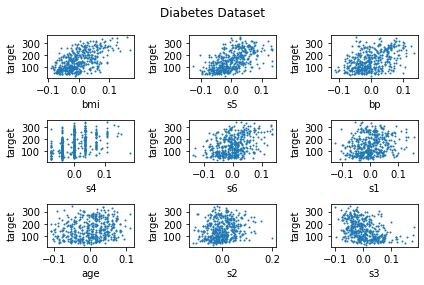

In [29]:
feat_names = list(correlated_feats.keys())

# Plotting simple scatter plots for the more correlated features
fig, axs = plt.subplots(math.ceil(len(feat_names) / 3), 3)
fig.suptitle('Diabetes Dataset')

for i in range(math.ceil(len(feat_names) / 3)):
    for j in range(3):
        if (i * 3 + j + 1) > len(feat_names):
            break
        n = j + i * 3
        feature = feat_names[n]
        axs[i, j].scatter(sk_ds['data'][feature], sk_ds['target'], s=1)
        axs[i, j].set_xlabel(feature)
        axs[i, j].set_ylabel('target')
plt.tight_layout()
plt.show()


#### Now let's start the PCA Prep

In [30]:
# Binning the targets so we can use them to colour the PCA datapoints and hopefully see some clustering!
# Using quantile binning (and just naming them 0-9)
combined['target_binned'] = pd.qcut(combined['target'], q=10, labels=range(0,10)).astype('object')

In [31]:
# Data appears to be already scaled. Note that if this weren't scaled, we should do that before PCA as it isn't included
# as per the documentation:
# Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. 
# The input data is centered but not scaled for each feature before applying the SVD.
combined

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target,target_binned
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0,5
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0,1
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0,5
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0,7
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0,6
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0,3
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0,4
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0,7


In [32]:
# Fit a Principal Component Analysis Model on data!!
combined.iloc[:,0:-2]
model = PCA(n_components = 2)
model.fit(combined.iloc[:,0:-2])

PCA(n_components=2)

In [33]:
# See the first component (axis of largest variance, PC1)
model.components_[0]
# See the second component (axis of second largest variance, PC2)
model.components_[1]

array([ 0.04436721, -0.3865472 , -0.15628128, -0.138266  ,  0.57302691,
        0.45594185,  0.50623907, -0.06818072, -0.026187  , -0.08494884])

In [34]:
# And this is what our data looks like on these axis
transformed_data = model.transform(combined.iloc[:,0:-2])


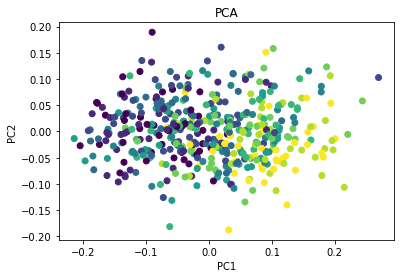

In [35]:
plt.figure()
plt.title("PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.scatter(transformed_data[:,0], transformed_data[:,1], c=combined.iloc[:,-1])
plt.show()

#### Scree Plot
Let's make a [Scree Plot](https://en.wikipedia.org/wiki/Scree_plot) to check that the dimension reduction to PC1/PC2 was reasonable.
Code based off [this helpful tutorial](https://www.statology.org/scree-plot-python/)

In [36]:
# We need to re-fit the PCA with more dimensions than 2 (so we can compare them)
model = PCA(n_components=9)
model.fit(combined.iloc[:,0:-2])

PCA(n_components=9)

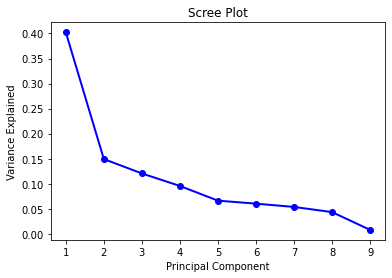

In [37]:
PC_values = np.arange(model.n_components_) + 1
plt.plot(PC_values, model.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [38]:
# Indeed looks like PC1 has strong variance
model.explained_variance_ratio_
# We see that PC1 accounts for 40% of total variation in dataset

array([0.40242108, 0.14923197, 0.12059663, 0.09554764, 0.06621814,
       0.06027171, 0.05365657, 0.0433682 , 0.007832  ])

In [39]:
print(model.feature_names_in_)
model.components_[0]

['age' 'sex' 'bmi' 'bp' 's1' 's2' 's3' 's4' 's5' 's6']


array([ 0.2164309 ,  0.18696688,  0.30316216,  0.27173773,  0.34325511,
        0.35186068, -0.28243681,  0.4288337 ,  0.37861802,  0.32218296])

### Observation of PCA
we can see some clustering per-colour, particularly along the PC1 axis

### Observation of Scree Plot
Indeed the first dimension (PC1) accounts for large variance

### Next time
I should have used a categorical classification problem to see the results better...live and learn